# Using B Splines to solve ODEs

The goal of this project is to use B-Splines, a generalization of Bernstein polynomials, to find numerical solutions to ODEs and systems of ODEs.

In [2]:
import numpy as np
from scipy.linalg import lu_factor, lu_solve
from scipy.linalg import qr, solve_triangular
import matplotlib as mpl
import matplotlib.pyplot as plt
import bspy

# ODE \#1

$$y'(t)=y(t),\qquad y(1)=1$$

In [36]:
degree = 3
nknots = 2
order = degree + 1
n = order + nknots
# Evenly spaced values between 0, 1 according to nknots
knots = np.linspace(0, 1, num=nknots + 2)
# Add 0s and 1s to the start and end of the knots list for endpoint knots
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]])

# Collocation points
coll_points = np.linspace(0.0, 1.0, n - 1)
coll_mat = np.zeros((n, n))

# First row of matrix for initial condition
ic_t = 1
ic_val = 1

ix = np.searchsorted(knots, ic_t, side = 'right')
ix = min(ix, n)
bvalues = bspy.Spline.bspline_values(ix, knots, order, ic_t)
coll_mat[0, ix - order : ix] = bvalues

# Fill in rest of rows
for irow, t in enumerate(coll_points):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    # Get spline value
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    # Get derivative spline value
    bvaluesp = bspy.Spline.bspline_values(ix, knots, order, t, 1)
    
    # Enforce collocation scheme
    coll_mat[irow + 1, ix - order : ix] = bvaluesp - bvalues

print("Collocation Matrix: ")
print(np.around(coll_mat, decimals = 1))

Collocation Matrix: 
[[  0.    0.    0.    0.    0.    1. ]
 [-10.    9.    0.    0.    0.    0. ]
 [ -0.6  -2.8   1.7   0.8   0.    0. ]
 [  0.   -0.6  -2.2   1.2   0.5   0. ]
 [  0.    0.   -0.9  -2.6   1.9   0.5]
 [  0.    0.    0.    0.   -9.    8. ]]


(-0.05, 1.05, 0.3362734132300145, 1.0316060279414279)

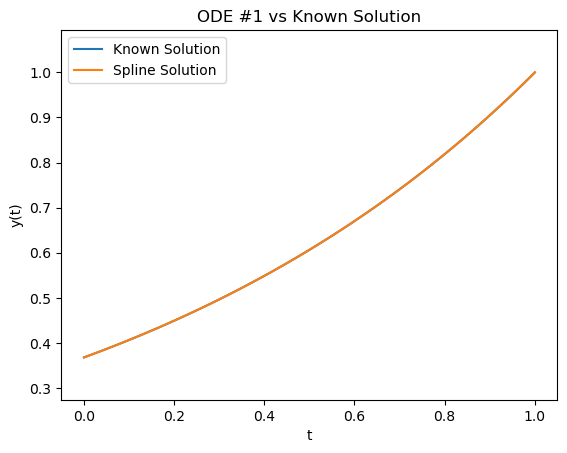

In [37]:
# Solve the collocation matrix for coeffs
rhs = np.zeros((n,))
# Initial Condition
rhs[0] = ic_val
lupiv = lu_factor(coll_mat)
alpha = lu_solve(lupiv, rhs)

# Plot spline vs known solution

u = bspy.Spline(1, 1, [order], [n], [knots], [alpha])
t = np.linspace(0.0, 1.0, 101)
truth = np.exp(t-1)
plt.plot(t, truth, label="Known Solution")
plt.plot(t, u(t), label="Spline Solution")
plt.legend()
plt.title("ODE #1 vs Known Solution")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.axis('equal')

# ODE \#2

$$y''(t)=y(t),\qquad y(0)=1,\quad y(1)=1$$


In [9]:
degree = 3
nknots = 2
order = degree + 1
n = order + nknots
# Evenly spaced values between 0, 1 according to nknots
knots = np.linspace(0, 1, num=nknots + 2)
# Add 0s and 1s to the start and end of the knots list for endpoint knots
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]])

# Collocation Points
coll_points = np.linspace(0.0, 1.0, n - 2)
coll_mat = np.zeros((n, n))

# First two rows of matrix for initial conditions
ic_t = [0, 1]
ic_val = [1, 1]

# First Initial Condition
ix = np.searchsorted(knots, ic_t[0], side = 'right')
ix = min(ix, n)
bvalues = bspy.Spline.bspline_values(ix, knots, order, ic_t[0])
coll_mat[0, ix - order : ix] = bvalues

# Second Initial condition
ix = np.searchsorted(knots, ic_t[1], side = 'right')
ix = min(ix, n)
bvalues = bspy.Spline.bspline_values(ix, knots, order, ic_t[1])
coll_mat[1, ix - order : ix] = bvalues

# Fill in rest of rows
for irow, t in enumerate(coll_points):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    # Get spline value
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    # Get second derivative spline value
    bvaluesp = bspy.Spline.bspline_values(ix, knots, order, t, 2)
    
    # Enforce Collocation Scheme
    coll_mat[irow + 2, ix - order : ix] = bvaluesp - bvalues

print("Collocation Matrix: ")
print(np.around(coll_mat, decimals = 1))

Collocation Matrix: 
[[  1.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    1. ]
 [ 53.  -81.   27.    0.    0.    0. ]
 [  0.   13.2 -23.1   8.8   0.    0. ]
 [  0.    0.    8.8 -23.1  13.2   0. ]
 [  0.    0.    0.   27.  -81.   53. ]]


(-0.05, 1.05, 0.8801200564971753, 1.00570856873823)

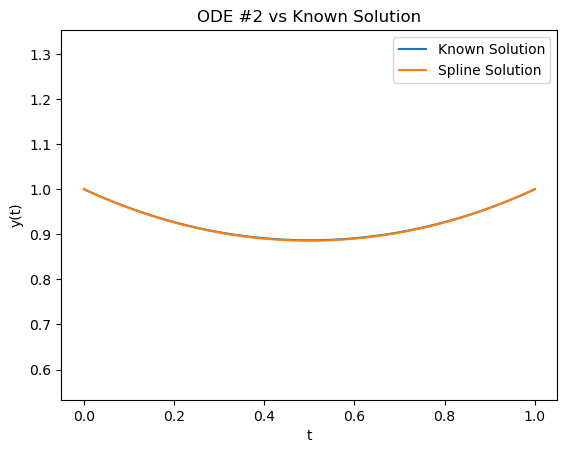

In [10]:
# Solve the collocation matrix for coeffs
rhs = np.zeros((n))
# Initial Condition
for i, val in enumerate(ic_val):
    rhs[i] = val
lupiv = lu_factor(coll_mat)
alpha = lu_solve(lupiv, rhs)

# Plot spline vs known solution
u = bspy.Spline(1, 1, [order], [n], [knots], [alpha])
u(0.0), u(0.5), u(1.0)
t = np.linspace(0.0, 1.0, 101)
e = np.exp(1)
truth = (1-(e**2-e)/(e**2-1)) * e**t + ((e**2-e)/(e**2-1)) * e**-t
plt.plot(t, truth, label="Known Solution")
plt.plot(t, u(t), label="Spline Solution")
plt.legend()
plt.title("ODE #2 vs Known Solution")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.axis('equal')

# ODE \#3

$$y'(t)=\begin{pmatrix}0 & -\pi\cr \pi & 0\cr\end{pmatrix}y(t),\qquad y(0)=\begin{pmatrix}1\cr 0\cr\end{pmatrix}$$


In [17]:
degree = 3
nknots = 2
order = degree + 1
n = order + nknots

# Evenly spaced values between 0, 1 according to nknots
knots = np.linspace(0, 1, num=nknots + 2)
# Add 0s and 1s to the start and end of the knots list for endpoint knots
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]])

# Collocation Points
coll_points = np.linspace(0.0, 1.0, n-1)
coll_mat = np.zeros((n*2, n*2))

# First row for each function used for initial condition
ic_t = [0, 0]
ic_val = [1, 0]

# Set each initial condition
for i, t in enumerate(ic_t):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    coll_mat[i, 2*(ix - order) + i : 2*ix + i:2] = bvalues

# Fill in rest of rows
for irow, t in enumerate(coll_points):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    
    # Get spline value
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    # Get derivative spline value
    bvaluesp = bspy.Spline.bspline_values(ix, knots, order, t, 1)
    
    # Next row: First Equation
    
    # First Function
    coll_mat[2 + 2 * irow, 2 * (ix - order) : 2 * ix: 2] = bvaluesp
    # Second Function
    coll_mat[2 + 2 * irow, 2 * (ix - order) + 1: 2 * ix + 1: 2] += np.pi * bvalues
    
    # 2nd Next row: Second Equation
    
    # First Function
    coll_mat[2 + 2 * irow + 1, 2 * (ix - order) : 2 * ix: 2] -= np.pi * bvalues
    # Second Function
    coll_mat[2 + 2 * irow + 1, 2 * (ix - order) + 1 : 2 * ix + 1: 2] = bvaluesp

print("Collocation Matrix: ")
print(np.around(coll_mat, decimals = 1))

Collocation Matrix: 
[[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-9.   3.1  9.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-3.1 -9.   0.   9.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.6  0.  -2.4  1.4  2.1  1.4  0.8  0.2  0.   0.   0.   0. ]
 [-0.  -0.6 -1.4 -2.4 -1.4  2.1 -0.2  0.8  0.   0.   0.   0. ]
 [ 0.   0.  -0.6  0.1 -1.7  1.5  1.7  1.5  0.6  0.1  0.   0. ]
 [ 0.   0.  -0.1 -0.6 -1.5 -1.7 -1.5  1.7 -0.1  0.6  0.   0. ]
 [ 0.   0.   0.   0.  -0.8  0.2 -2.1  1.4  2.4  1.4  0.6  0. ]
 [ 0.   0.   0.   0.  -0.2 -0.8 -1.4 -2.1 -1.4  2.4 -0.   0.6]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -9.   0.   9.   3.1]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -9.  -3.1  9. ]]


(-1.0999804666258368,
 1.0999990698393258,
 -0.04931934441587388,
 1.035706232733349)

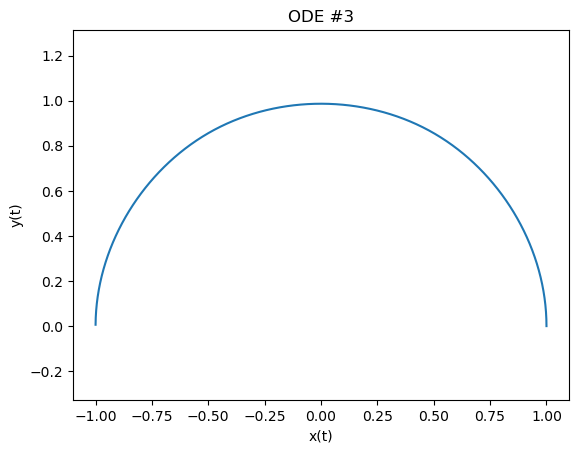

In [18]:
# Solve the collocation matrix for coeffs
rhs = np.zeros((n * 2,))
# Initial Conditions
for i, val in enumerate(ic_val):
    rhs[i] = val
lupiv = lu_factor(coll_mat)
alpha = lu_solve(lupiv, rhs)

# Plot splines
coeffs = alpha.reshape((6, 2))
u = bspy.Spline(1, 2, [order], [n], [knots], coeffs)
t = np.linspace(0.0, 1.0, 101)
# Plot x(t) vs. y(t)
plt.plot(u(t)[0], u(t)[1])
plt.title("ODE #3")
plt.xlabel("x(t)")
plt.ylabel("y(t)")
plt.axis('equal')

# ODE \#4

$$y'(t)=2ty(t),\qquad y(0)=1$$

In [25]:
degree = 3
nknots = 2
order = degree + 1
n = order + nknots
# Evenly spaced values between 0, 1 according to nknots
knots = np.linspace(0, 1, num=nknots + 2)
# Add 0s and 1s to the start and end of the knots list for endpoint knots
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]])

# Collocation Points
coll_points = np.linspace(0.0, 1.0, n - 1)
coll_mat = np.zeros((n, n))

# First row of matrix for initial condition
ic_t = 0
ic_val = 1

ix = np.searchsorted(knots, ic_t, side = 'right')
ix = min(ix, n)
bvalues = bspy.Spline.bspline_values(ix, knots, order, ic_t)
coll_mat[0, ix - order : ix] = bvalues

# Fill in rest of rows
for irow, t in enumerate(coll_points):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    # Get spline value
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    # Get derivative spline value
    bvaluesp = bspy.Spline.bspline_values(ix, knots, order, t, 1)
    
    # Enforce collocation scheme
    coll_mat[irow + 1, ix - order : ix] = bvaluesp - 2 * t * bvalues

print("Collocation Matrix: ")
print(np.around(coll_mat, decimals = 1))
print(np.linalg.cond(coll_mat))

Collocation Matrix: 
[[ 1.   0.   0.   0.   0.   0. ]
 [-9.   9.   0.   0.   0.   0. ]
 [-0.6 -2.6  1.9  0.8  0.   0. ]
 [ 0.  -0.6 -2.2  1.2  0.5  0. ]
 [ 0.   0.  -0.9 -2.8  1.7  0.5]
 [ 0.   0.   0.   0.  -9.   7. ]]
55.92581862807047


(-0.05, 1.05, 0.9137033499913554, 2.8122296501815374)

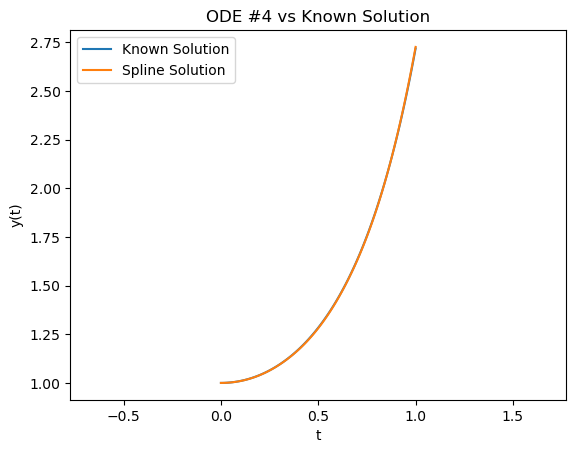

In [26]:
# Solve the collocation matrix for coeffs
rhs = np.zeros((n,))
# Initial Condition
rhs[0] = ic_val
lupiv = lu_factor(coll_mat)
alpha = lu_solve(lupiv, rhs)

# Plot spline vs real function

u = bspy.Spline(1, 1, [order], [n], [knots], [alpha])
t = np.linspace(0.0, 1.0, 101)
truth = np.exp((t**2))
plt.plot(t, truth, label="Known Solution")
plt.plot(t, u(t), label="Spline Solution")
plt.legend()
plt.title("ODE #4 vs Known Solution")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.axis('equal')

# ODE \#5

 $$y''(t)=a(t)y(t)+b(t)y'(t)+c(t),\qquad y(0)=1,\qquad y(1)=-1$$

 Choose $a(t)=5t^2-200$, $b(t)=5-10t-5t^2$, and $c(t)=\cos t + 3t + 1$

 Plot $y(t)$ versus $t$

In [27]:
# Define coefficient functions
def a(t):
    return 5 * t ** 2 - 200

def b(t):
    return 5 - 10 * t - 5 * t ** 2

def c(t):
    return np.cos(t) + 3 * t + 1

In [38]:
degree = 3
nknots = 40
order = degree + 1
n = order + nknots
# Evenly spaced values between 0, 1 according to nknots
knots = np.linspace(0, 1, num=nknots + 2)
# Add 0s and 1s to the start and end of the knots list for endpoint knots
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]])

# Collocation Points
coll_points = np.linspace(0.0, 1.0, n - 2)
coll_mat = np.zeros((n, n))

# First two rows of matrix for initial conditions
ic_t = [0, 1]
ic_val = [1, -1]

# First Initial Condition
ix = np.searchsorted(knots, ic_t[0], side = 'right')
ix = min(ix, n)
bvalues = bspy.Spline.bspline_values(ix, knots, order, ic_t[0])
coll_mat[0, ix - order : ix] = bvalues

# Second Initial condition
ix = np.searchsorted(knots, ic_t[1], side = 'right')
ix = min(ix, n)
bvalues = bspy.Spline.bspline_values(ix, knots, order, ic_t[1])
coll_mat[1, ix - order : ix] = bvalues

# Fill in rest of rows
for irow, t in enumerate(coll_points):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    # Get spline value
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    # Get 1st derivative spline value
    bvaluesd1 = bspy.Spline.bspline_values(ix, knots, order, t, 1)
    # Get 2nd derivative spline value
    bvaluesd2 = bspy.Spline.bspline_values(ix, knots, order, t, 2)
    
    # Enforce Collocation Scheme
    coll_mat[irow + 2, ix - order : ix] = bvaluesd2 - a(t) * bvalues - b(t) * bvaluesd1 - c(t)

print("Collocation Matrix: ")
print(np.around(coll_mat, decimals = 1))
print(np.linalg.cond(coll_mat))

Collocation Matrix: 
[[ 1.00000e+00  0.00000e+00  0.00000e+00 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ...  0.00000e+00  0.00000e+00
   1.00000e+00]
 [ 1.08990e+04 -1.57460e+04  5.04100e+03 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 ...
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ...  1.89440e+03 -4.40000e+00
   0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ... -4.19060e+03  2.85840e+03
  -4.50000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ...  5.03850e+03 -1.63635e+04
   1.15065e+04]]
576225.355253988


[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


Text(0, 0.5, 'y(t)')

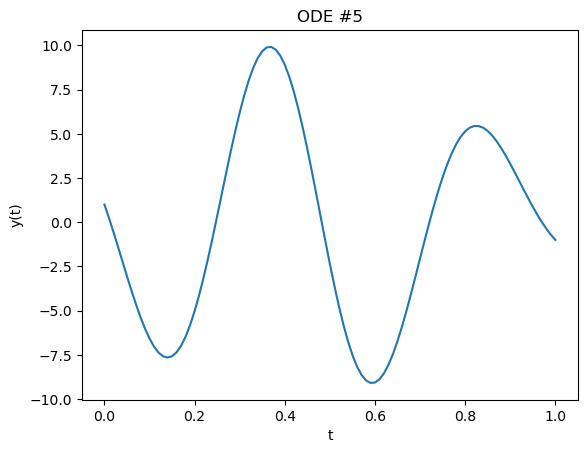

In [41]:
# Solve the collocation matrix for coeffs
rhs = np.zeros((n))
# Initial Conditions
for i, val in enumerate(ic_val):
    rhs[i] = val
print(rhs)
lupiv = lu_factor(coll_mat)
alpha = lu_solve(lupiv, rhs)

# Plot spline
u = bspy.Spline(1, 1, [order], [n], [knots], [alpha])
t = np.linspace(0.0, 1.0, 101)
plt.plot(t, u(t))
plt.title("ODE #5")
plt.xlabel("t")
plt.ylabel("y(t)")

# ODE \#6

$$y''(t)=\begin{pmatrix}-1 & 0 & 1 & 0\cr 0 & -1 & 0 & 1\cr
1 & 0 & -1 & 0\cr 0 & 1 & 0 & -1\cr\end{pmatrix}y(t)-2y'(t),\qquad
y(0)=\begin{pmatrix}0\cr 0.5\cr 1\cr 0.5\cr\end{pmatrix},\qquad
y(1)=\begin{pmatrix}0.7\cr 0.9\cr 0.3\cr 0.1\cr\end{pmatrix}$$

Plot $y_2(t)$ versus $y_1(t)$ and $y_4(t)$ versus $y_3(t)$

In [42]:
degree = 3
nknots = 2
order = degree + 1
n = order + nknots

# Evenly spaced values between 0, 1 according to nknots
knots = np.linspace(0, 1, num=nknots + 2)
# Add 0s and 1s to the start and end of the knots list for endpoint knots
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]])

# Collocation Points
coll_points = np.linspace(0.0, 1.0, n-2)
coll_mat = np.zeros((n*4, n*4))

# First eight rows of matrix for initial conditions

# First set
ic_t1 = [0, 0, 0, 0]
ic_val1 = [0.45, 0.5, 0.55, 0.5]

for i, t in enumerate(ic_t1):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    coll_mat[i, 4*(ix - order) + i : 4*ix + i:4] = bvalues

# 2nd set
ic_t2 = [1, 1, 1, 1]
ic_val2 = [0.6, 0.4, 0.4, 0.4]

for i, t in enumerate(ic_t2):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    coll_mat[i + 4, 4*(ix - order) + i : 4*ix + i:4] = bvalues

# Coefficient matrix for y(t)
coeff_matrix = -np.array([[-1, 0, 1, 0], [0, -1, 0, 1], [1, 0, -1, 0], [0, 1, 0, -1]])

# Fill in rest of rows
for irow, t in enumerate(coll_points):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    
    # Get spline value
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    # Get 1st derivative spline value
    bvaluesd1 = bspy.Spline.bspline_values(ix, knots, order, t, 1)
    # Get 2nd derivative spline value
    bvaluesd2 = bspy.Spline.bspline_values(ix, knots, order, t, 2)
    
    # Stagger equations by rows, functions by columns
    for iro, corow in enumerate(coeff_matrix):
        for ico, co in enumerate(corow):
            if ico == iro:
                d2_d1 = bvaluesd2 + 2 * bvaluesd1
            else:
                d2_d1 = 0
            coll_mat[8 + 4 * irow + iro, 4 * (ix - order) + ico : 4 * ix + ico: 4] += d2_d1 + co * bvalues
    
print("Collocation Matrix: ")
print(np.around(coll_mat, decimals = 1))

Collocation Matrix: 
[[  1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.

(0.38929977494799023,
 0.6107002250520098,
 0.3949999999999999,
 0.5050000000000019)

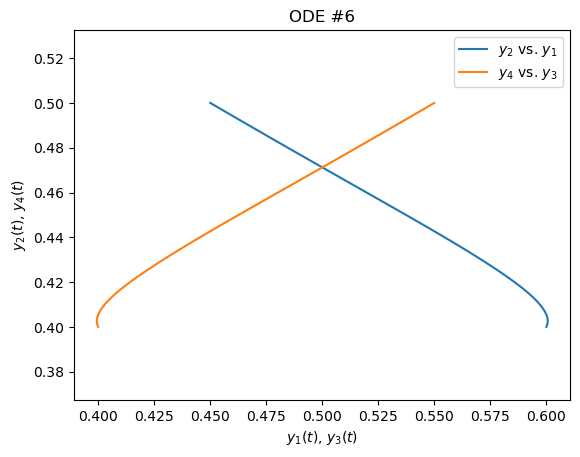

In [43]:
# Solve the collocation matrix for coeffs
rhs = np.zeros((n * 4,))
# First set of initial conditions
for i, val in enumerate(ic_val1):
    rhs[i] = val
    
# Second set of initial conditions
for i, val in enumerate(ic_val2):
    rhs[i + 4] = val

lupiv = lu_factor(coll_mat)
alpha = lu_solve(lupiv, rhs)

# Plot splines
coeffs = alpha.reshape((6, 4))
u = bspy.Spline(1, 4, [order], [n], [knots], coeffs)
t = np.linspace(0.0, 1.0, 101)
plt.plot(u(t)[0], u(t)[1], label="$y_2$ vs. $y_1$")
plt.plot(u(t)[2], u(t)[3], label="$y_4$ vs. $y_3$")
plt.title("ODE #6")
plt.ylabel("$y_2(t)$, $y_4(t)$")
plt.xlabel("$y_1(t)$, $y_3(t)$")
plt.legend()
plt.axis('equal')